In [1]:
import pandas as pd
file = ("D:/Task/Intern Housing Data India.csv")
data = pd.read_csv(file)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

C:\Users\Harihara Sudhan N\AppData\Local\Temp\ipykernel_34060\4229720850.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['total_rooms'].fillna(data['total_rooms'].median(), inplace=True)


longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64 Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')


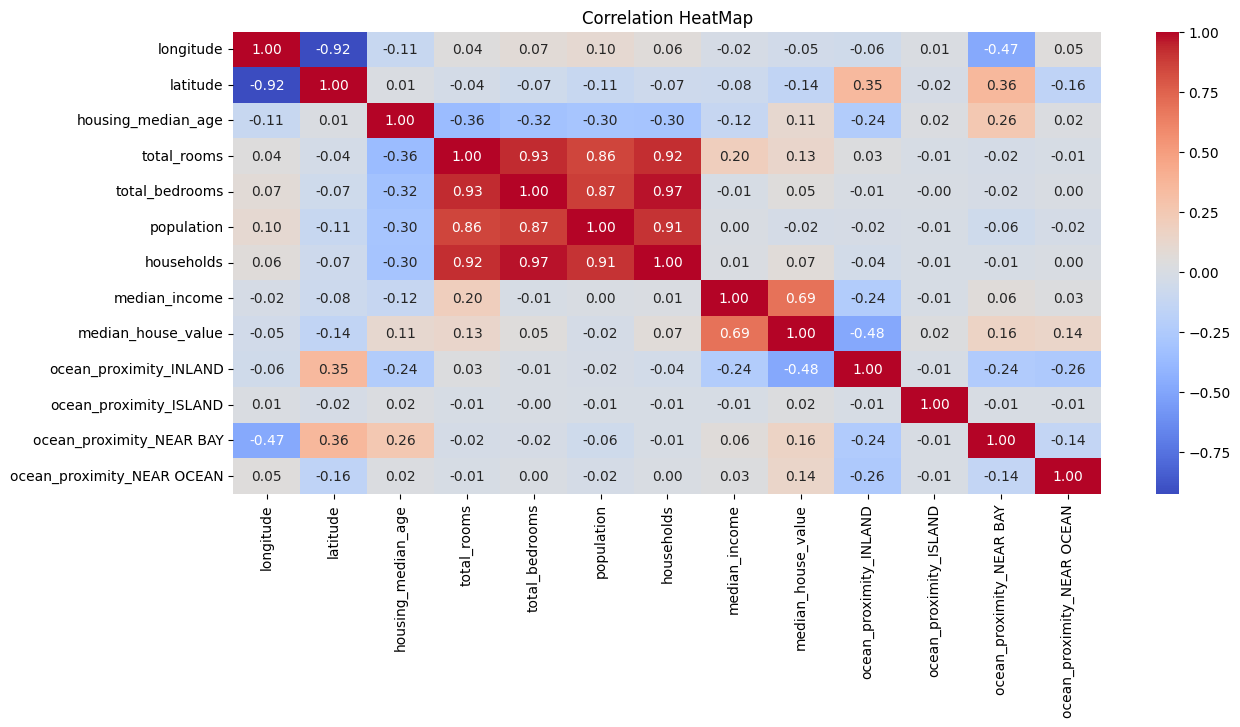

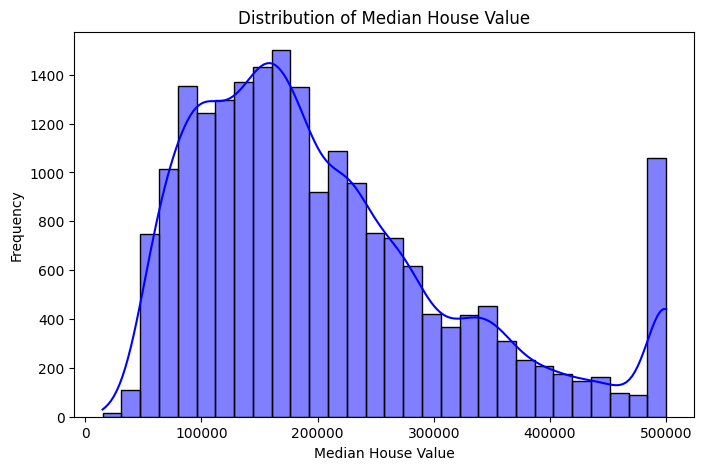

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary stats for dataset
#stats = data.describe()

# Check for missing values in each column
missing_values = data.isnull().sum()

# Handle missing values in `total_bedrooms` by imputing with the median
data['total_rooms'].fillna(data['total_rooms'].median(), inplace=True)

# Encode the `ocean_proximity` column using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['ocean_proximity'], dtype=float, drop_first=True)

# Verify the changes
missing_values_after_imputation = data_encoded.isnull().sum()
encoded_columns = data_encoded.columns

print(missing_values_after_imputation, encoded_columns)

# Visualizations: Correlation heatmap and distribution of the target variable
plt.figure(figsize=(14, 6))
sns.heatmap(data_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
#sns.scatterplot(x=data['median_house_value'], y=data['median_income'], alpha = 0.6, color = 'blue')
plt.title("Correlation HeatMap")
#plt.xlabel('Median Income', fontsize=12)
#plt.ylabel("Meddian House Value", fontsize=12)
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(data['median_house_value'], kde=True, bins=30, color='blue')
plt.title("Distribution of Median House Value")
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.show()


In [26]:
from sklearn.model_selection import train_test_split

# Define features and target variable
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
            'total_bedrooms', 'population', 'households', 'median_income',
            'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
            'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN']
target = 'median_house_value'

# Split data into training and testing sets
X = data_encoded[features]
y = data_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((16512, 12), (4128, 12), (16512,), (4128,))

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

model = RandomForestRegressor(n_estimators=100, random_state=36)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R^2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


R^2 Score: 0.8161
RMSE: 49085.26


In [37]:
import joblib

joblib.dump(model, 'house_price.pkl')

['house_price.pkl']

In [39]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

model = joblib.load('house_price.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    features = [
        data['longitude'], data['latitude'], data['housing_median_age'], 
        data['total_rooms'], data['total_bedrooms'], data['population'],
        data['households'], data['median_income'], data['ocean_proximity_INLAND'],
        data['ocean_proximity_ISLAND'], data['ocean_proximity_NEAR BAY'],
        data['ocean_proximity_NEAR OCEAN'], data['ocean_proximity_<1H OCEAN']
    ]

    prediction = model.predict([features])

    return jsonify({'predicted_price': prediction[0]})

if __name__ == '__main__':
    app.run(debug=True, port=5001)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\Harihara Sudhan N\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
